# Demo of functionalities in QAOA Utilities

This notebooks walks through some of the key features provided by `QAOA.utilities`. The methods therein fall into three categories:

* Methods for creating random graphs and Hamiltonians, and converting between the two.
* Methods for creating certain types of toy data sets (e.g. combos of separate Gaussians), which may be used e.g. for simple clustering with the QAOA.
* Methods allowing parameter sweeps to be performed, with a view to studying the landscape of the optimisation problem being tackled.
* Functions that compute analytic results for certain graphs (will use exact formulae from papers by Farhi, Hadfield, etc) to benchmark and compare against numerical results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Type, Iterable

# import the neccesary pyquil modules
from qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm

# import the QAOAParameters that we want to demo
from qaoa.parameters import AdiabaticTimestepsQAOAParameters,\
AlternatingOperatorsQAOAParameters, AbstractQAOAParameters, GeneralQAOAParameters,\
QAOAParameterIterator, FourierQAOAParameters

from vqe.optimizer import scipy_optimizer
import utilities as ut

## Random Hamiltonians and graphs

The `create_random_hamiltonian` method generates a random Hamiltonian (problem instance) for a specified number of qubits. It randomly selects a number of biases and number of couplings, then assigns each of them a random value between zero and one. For instance, let's create two 4-qubit Hamiltonians.

In [2]:
h1 = ut.create_random_hamiltonian(4)
h2 = ut.create_random_hamiltonian(4)
print("h1 =",h1)
print()
print("h2 =",h2)

h1 = (0.1979562962433411+0j)*Z0 + (0.177200519669939+0j)*Z2 + (0.892121698987402+0j)*Z0*Z1 + (0.003777218103473645+0j)*Z0*Z3 + (0.5840350223329037+0j)*Z1*Z2 + (0.21841249341654745+0j)*Z2*Z3

h2 = (0.09498316078189661+0j)*Z0*Z3


We can create a `networkx` graph corresponding to the qubit couplings in `h1` using the `AbstractQAOAParameters` class, together with the `create_networkx_graph` method:

In [3]:
myAbstractParams = AbstractQAOAParameters([h1,1]) # Here we have to pass in a timestep value too - can/should we clean this up?
print(myAbstractParams)

Hyperparameters:
	register: [0, 1, 2, 3]
	qubits_singles: [0, 2]
	single_qubit_coeffs: [0.1979563  0.17720052]
	qubits_pairs: [[0, 1], [0, 3], [1, 2], [2, 3]]
	pair_qubit_coeffs: [0.8921217  0.00377722 0.58403502 0.21841249]
	timesteps: 1



/home/ewan/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


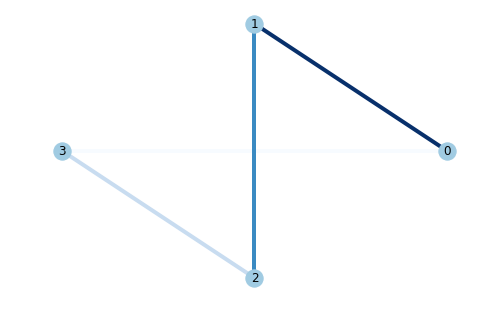

In [4]:
g1 = ut.networkx_from_hamiltonian(myAbstractParams.qubits_pairs,myAbstractParams.pair_qubit_coeffs)
ut.plot_networkx_graph(g1)

We can alternatively work backwards, creating a graph first, then the corresponding Hamiltonian. Let's take the graph we have just produced (`g1`) and convert it back to its corresponding Hamiltonian, which we called `h1` above. Neglecting any missing single qubit bias terms, we see that `H1` here is the same as `h1` defined above.

In [5]:
H1 = ut.hamiltonian_from_networkx(g1)
print(H1)

(0.892121698987402+0j)*Z0*Z1 + (0.003777218103473645+0j)*Z0*Z3 + (0.5840350223329037+0j)*Z1*Z2 + (0.21841249341654745+0j)*Z3*Z2


TODO - include & showcase functionality for not entirely random graphs, e.g.:

* graphs with a specified maximum node degree
* graphs with/without triangles, etc.
* Farhi's "ring of disagrees"
* Erdos-Renyi, geometric random, etc

## Simple toy datasets for QAOA MaxCut clustering

Here we demo some of the methods for generating simple datasets for QAOA clustering problems. Let's create a data set of two clusters, where the points in each cluster follow Gaussian statistics.

In [ ]:
n_clusters = 2
n_points = 3 # Number of points in each cluster
means = [[0,0], [2,2]] # Cluster means 

myData1 = create_gaussian_2Dclusters(n_clusters,n_points,means,variances,covs)